# Scenario 2
## Background
(copied from scenario 2 description)

_The Delta variant is beginning to spread around the country, including in New York
state. Vaccine campaigns have been underway in select groups since the early part of 2021, but
the distribution process has a long tail and is still ongoing._

**Assumptions:**
- Children 0-10 cannot be vaccinated
- Let 𝑅(0) = 𝑐𝑢𝑚𝑢𝑙𝑎𝑡𝑖𝑣𝑒 𝑖𝑛𝑓𝑒𝑐𝑡𝑖𝑜𝑛𝑠 – 𝑐𝑢𝑚𝑢𝑙𝑎𝑡𝑖𝑣𝑒 𝑑𝑒𝑎𝑡ℎ𝑠, as of July 15 th , 2021.
- Let 𝐸(0) = 𝐼(0)/4
- Let 𝑆(0) = 𝑁 – 𝐸(0) − 𝐼(0) − 𝑅(0) − 𝐻(0) − 𝐷(0)

## Get model from scenario1

In [1]:
# Imports & setup
import sympy
from copy import deepcopy as _d
from mira.metamodel import *
from mira.modeling import Model
from mira.modeling.askenet.petrinet import AskeNetPetriNetModel
from mira.modeling.viz import GraphicalModel

# Units
person_units = lambda: Unit(expression=sympy.Symbol('person'))
day_units = lambda: Unit(expression=sympy.Symbol('day'))
per_day_units = lambda: Unit(expression=1/sympy.Symbol('day'))
dimensionless_units = lambda: Unit(expression=sympy.Integer('1'))
per_day_per_person_units = lambda: Unit(expression=1/(sympy.Symbol('day')*sympy.Symbol('person')))

# Concepts
c = {
    'S': Concept(name='S', units=person_units(), identifiers={'ido': '0000514'}),
    'E': Concept(name='E', units=person_units(), identifiers={'apollosv': '0000154'}),
    'I': Concept(name='I', units=person_units(), identifiers={'ido': '0000511'}),
    'R': Concept(name='R', units=person_units(), identifiers={'ido': '0000592'}),
    'H': Concept(name='H', units=person_units(), identifiers={'ido': '0000511'},
                 context={'property': 'ncit:C25179'}),
    'D': Concept(name='D', units=person_units(), identifiers={'ncit': 'C28554'}),
}


N_val = 19_340_000

# I(0) from data-truth/truth-Cumulative Cases.csv @ https://github.com/reichlab/covid19-forecast-hub/tree/master/data-truth
I_val = 2123452

# D(0) from data-truth/truth-Cumulative Deaths.csv @ https://github.com/reichlab/covid19-forecast-hub/tree/master/data-truth
D_val = 53550

# H(0) from CSV at https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/g62h-syeh
# Column used: 'inpatient_beds_used_covid' for state == 'NY' and date == '2021/07/15'
H_val = 744

# Derived initial values according to evaluation description
E_val = I_val/4
R_val = I_val - D_val
S_val = N_val - E_val - I_val - R_val - H_val - D_val

# NOTE: Some parameter values are updated from Scenario 1
parameters = {
    'beta': Parameter(name='beta', value=0.8, units=per_day_per_person_units()),
    'r_E_to_I': Parameter(name='r_E_to_I', value=0.2, units=per_day_units()),
    'r_I_to_H': Parameter(name='r_I_to_H', value=0.1, units=per_day_units()),
    'p_I_to_H': Parameter(name='p_I_to_H', value=0.1, units=dimensionless_units()),
    'r_I_to_R': Parameter(name='r_I_to_R', value=0.07, units=per_day_units()),
    'p_I_to_R': Parameter(name='p_I_to_R', value=0.9, units=dimensionless_units()),
    'r_H_to_R': Parameter(name='r_H_to_R', value=0.1, units=per_day_units()),
    'p_H_to_R': Parameter(name='p_H_to_R', value=0.85, units=dimensionless_units()),
    'r_H_to_D': Parameter(name='r_H_to_D', value=0.1, units=per_day_units()),
    'p_H_to_D': Parameter(name='p_H_to_D', value=0.15, units=dimensionless_units()),
    'N': Parameter(name='N', value=N_val, units=person_units()),
}


initials = {
    'S': Initial(concept=Concept(name='S'), value=S_val),
    'E': Initial(concept=Concept(name='E'), value=E_val),
    'I': Initial(concept=Concept(name='I'), value=I_val),
    'R': Initial(concept=Concept(name='R'), value=R_val),
    'H': Initial(concept=Concept(name='H'), value=H_val),
    'D': Initial(concept=Concept(name='D'), value=D_val),
}

observables = {}

S, E, I, R, D, H, N, beta, r_E_to_I, r_E_to_H, r_I_to_H, p_I_to_H, r_I_to_R, p_I_to_R, r_H_to_R, p_H_to_R, r_H_to_D, p_H_to_D = \
    sympy.symbols('S E I R D H N beta r_E_to_I r_E_to_H r_I_to_H p_I_to_H r_I_to_R p_I_to_R r_H_to_R p_H_to_R r_H_to_D p_H_to_D')



In [2]:
t1 = ControlledConversion(subject=c['S'],
                          outcome=c['E'],
                          controller=c['I'],
                          rate_law=S*I*beta / N)
t2 = NaturalConversion(subject=c['E'],
                       outcome=c['I'],
                       rate_law=r_E_to_I*E)
t3 = NaturalConversion(subject=c['I'],
                       outcome=c['R'],
                       rate_law=r_I_to_R*p_I_to_R*I)
t4 = NaturalConversion(subject=c['I'],
                       outcome=c['H'],
                       rate_law=r_I_to_H*p_I_to_H*I)
t5 = NaturalConversion(subject=c['H'],
                       outcome=c['R'],
                       rate_law=r_H_to_R*p_H_to_R*H)
t6 = NaturalConversion(subject=c['H'],
                       outcome=c['D'],
                       rate_law=r_H_to_D*p_H_to_D*H)
templates = [t1, t2, t3, t4, t5, t6]
tm = TemplateModel(
    templates=templates,
    parameters=parameters,
    initials=initials,
    time=Time(name='t', units=day_units()),
    observables=observables,
    annotations=Annotations(name='Evaluation Scenario 2 Base model')
)
AskeNetPetriNetModel(Model(tm)).to_json_file('eval_scenario2_base.json')

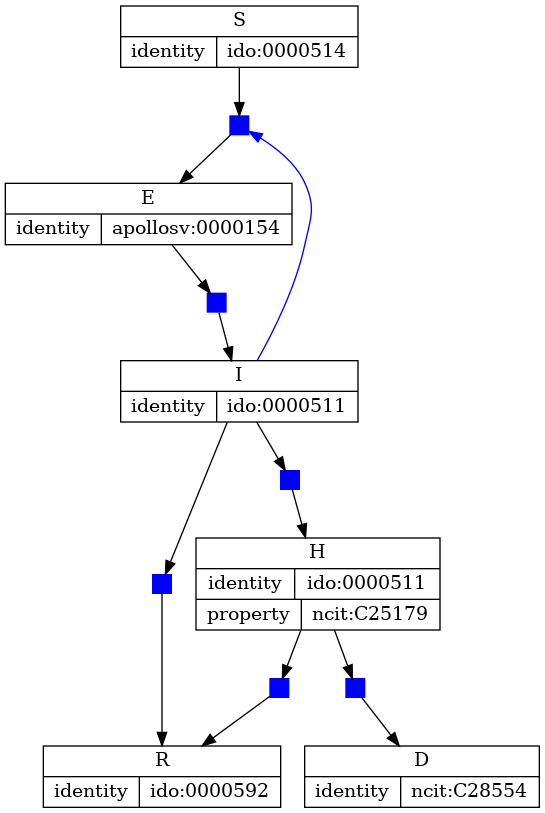

In [3]:
GraphicalModel.for_jupyter(tm)

## Update Scenario1 model
Update the model from Scenario 1 to have multiple vaccination compartments, one per vaccine (moderna, pfizer, J&J). For the mRNA vaccines, consider the number of primary series doses (1 or 2). Children ages 0-10 are not eligible for vaccination. Include masking (masked vs unmasked) for the unvaccinated population.

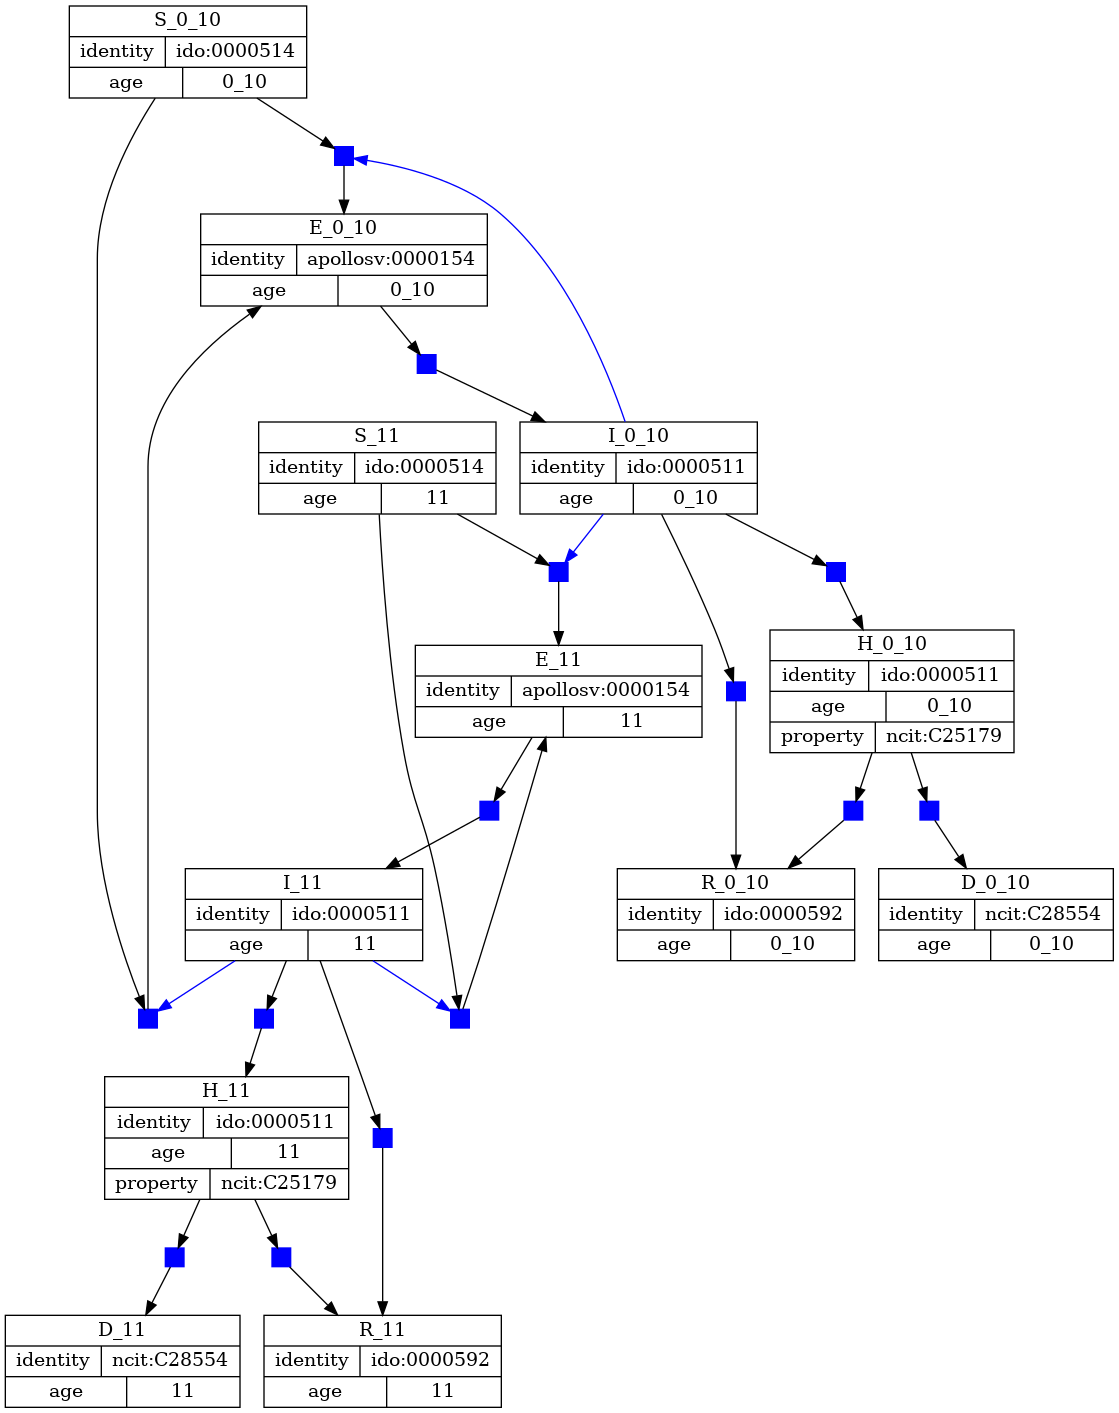

In [4]:
# Stratify by age, 0-10 and 11+
tm_age = stratify(
    tm,
    key='age',
    strata=['0_10', '11'],
    structure=[],
    cartesian_control=True,
    # No difference between age groups assumed
    params_to_preserve={p for p in tm.parameters}
)
GraphicalModel.for_jupyter(tm_age)

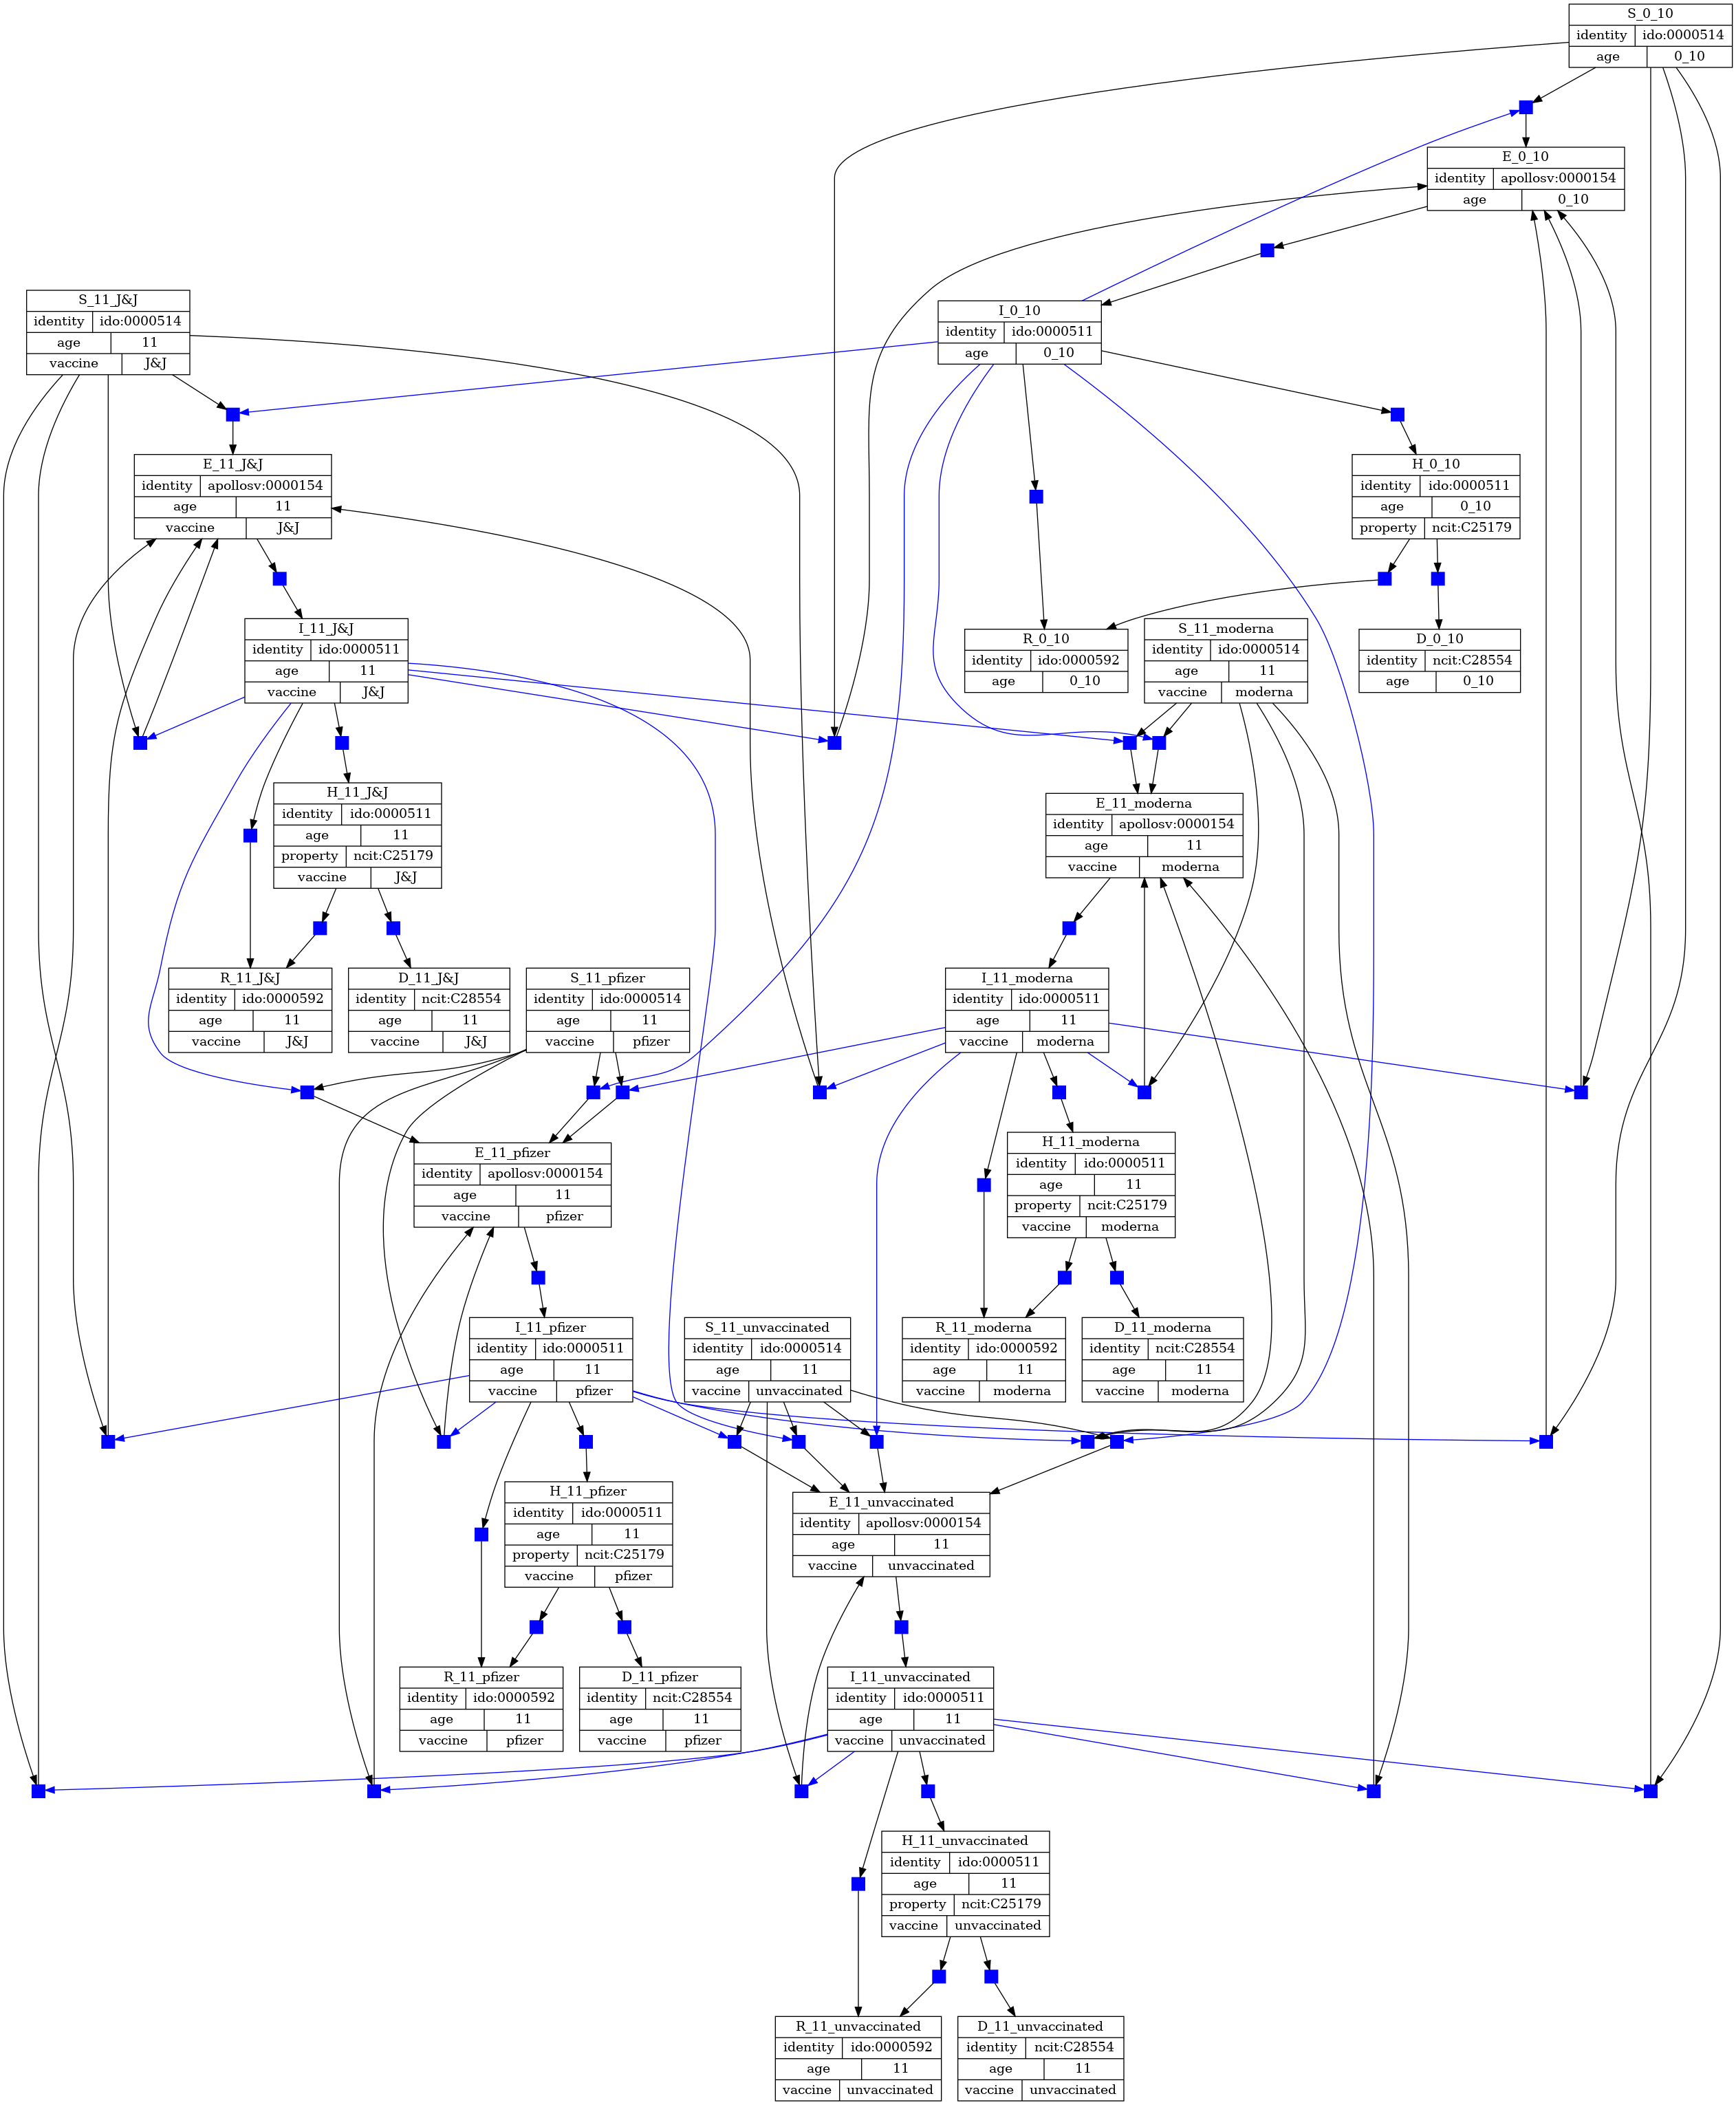

In [5]:
# Stratify the 11+ year-olds by vaccine
tm_vaccinated = stratify(
    tm_age,
    key='vaccine',
    strata=['unvaccinated', 'pfizer', 'moderna', 'J&J'],
    structure=[],
    cartesian_control=True,
    # beta is modified by vaccination status
    params_to_stratify={'beta'},
    concepts_to_stratify={"S_11", "E_11", "I_11", "R_11", "D_11", "H_11"}
)
GraphicalModel.for_jupyter(tm_vaccinated)

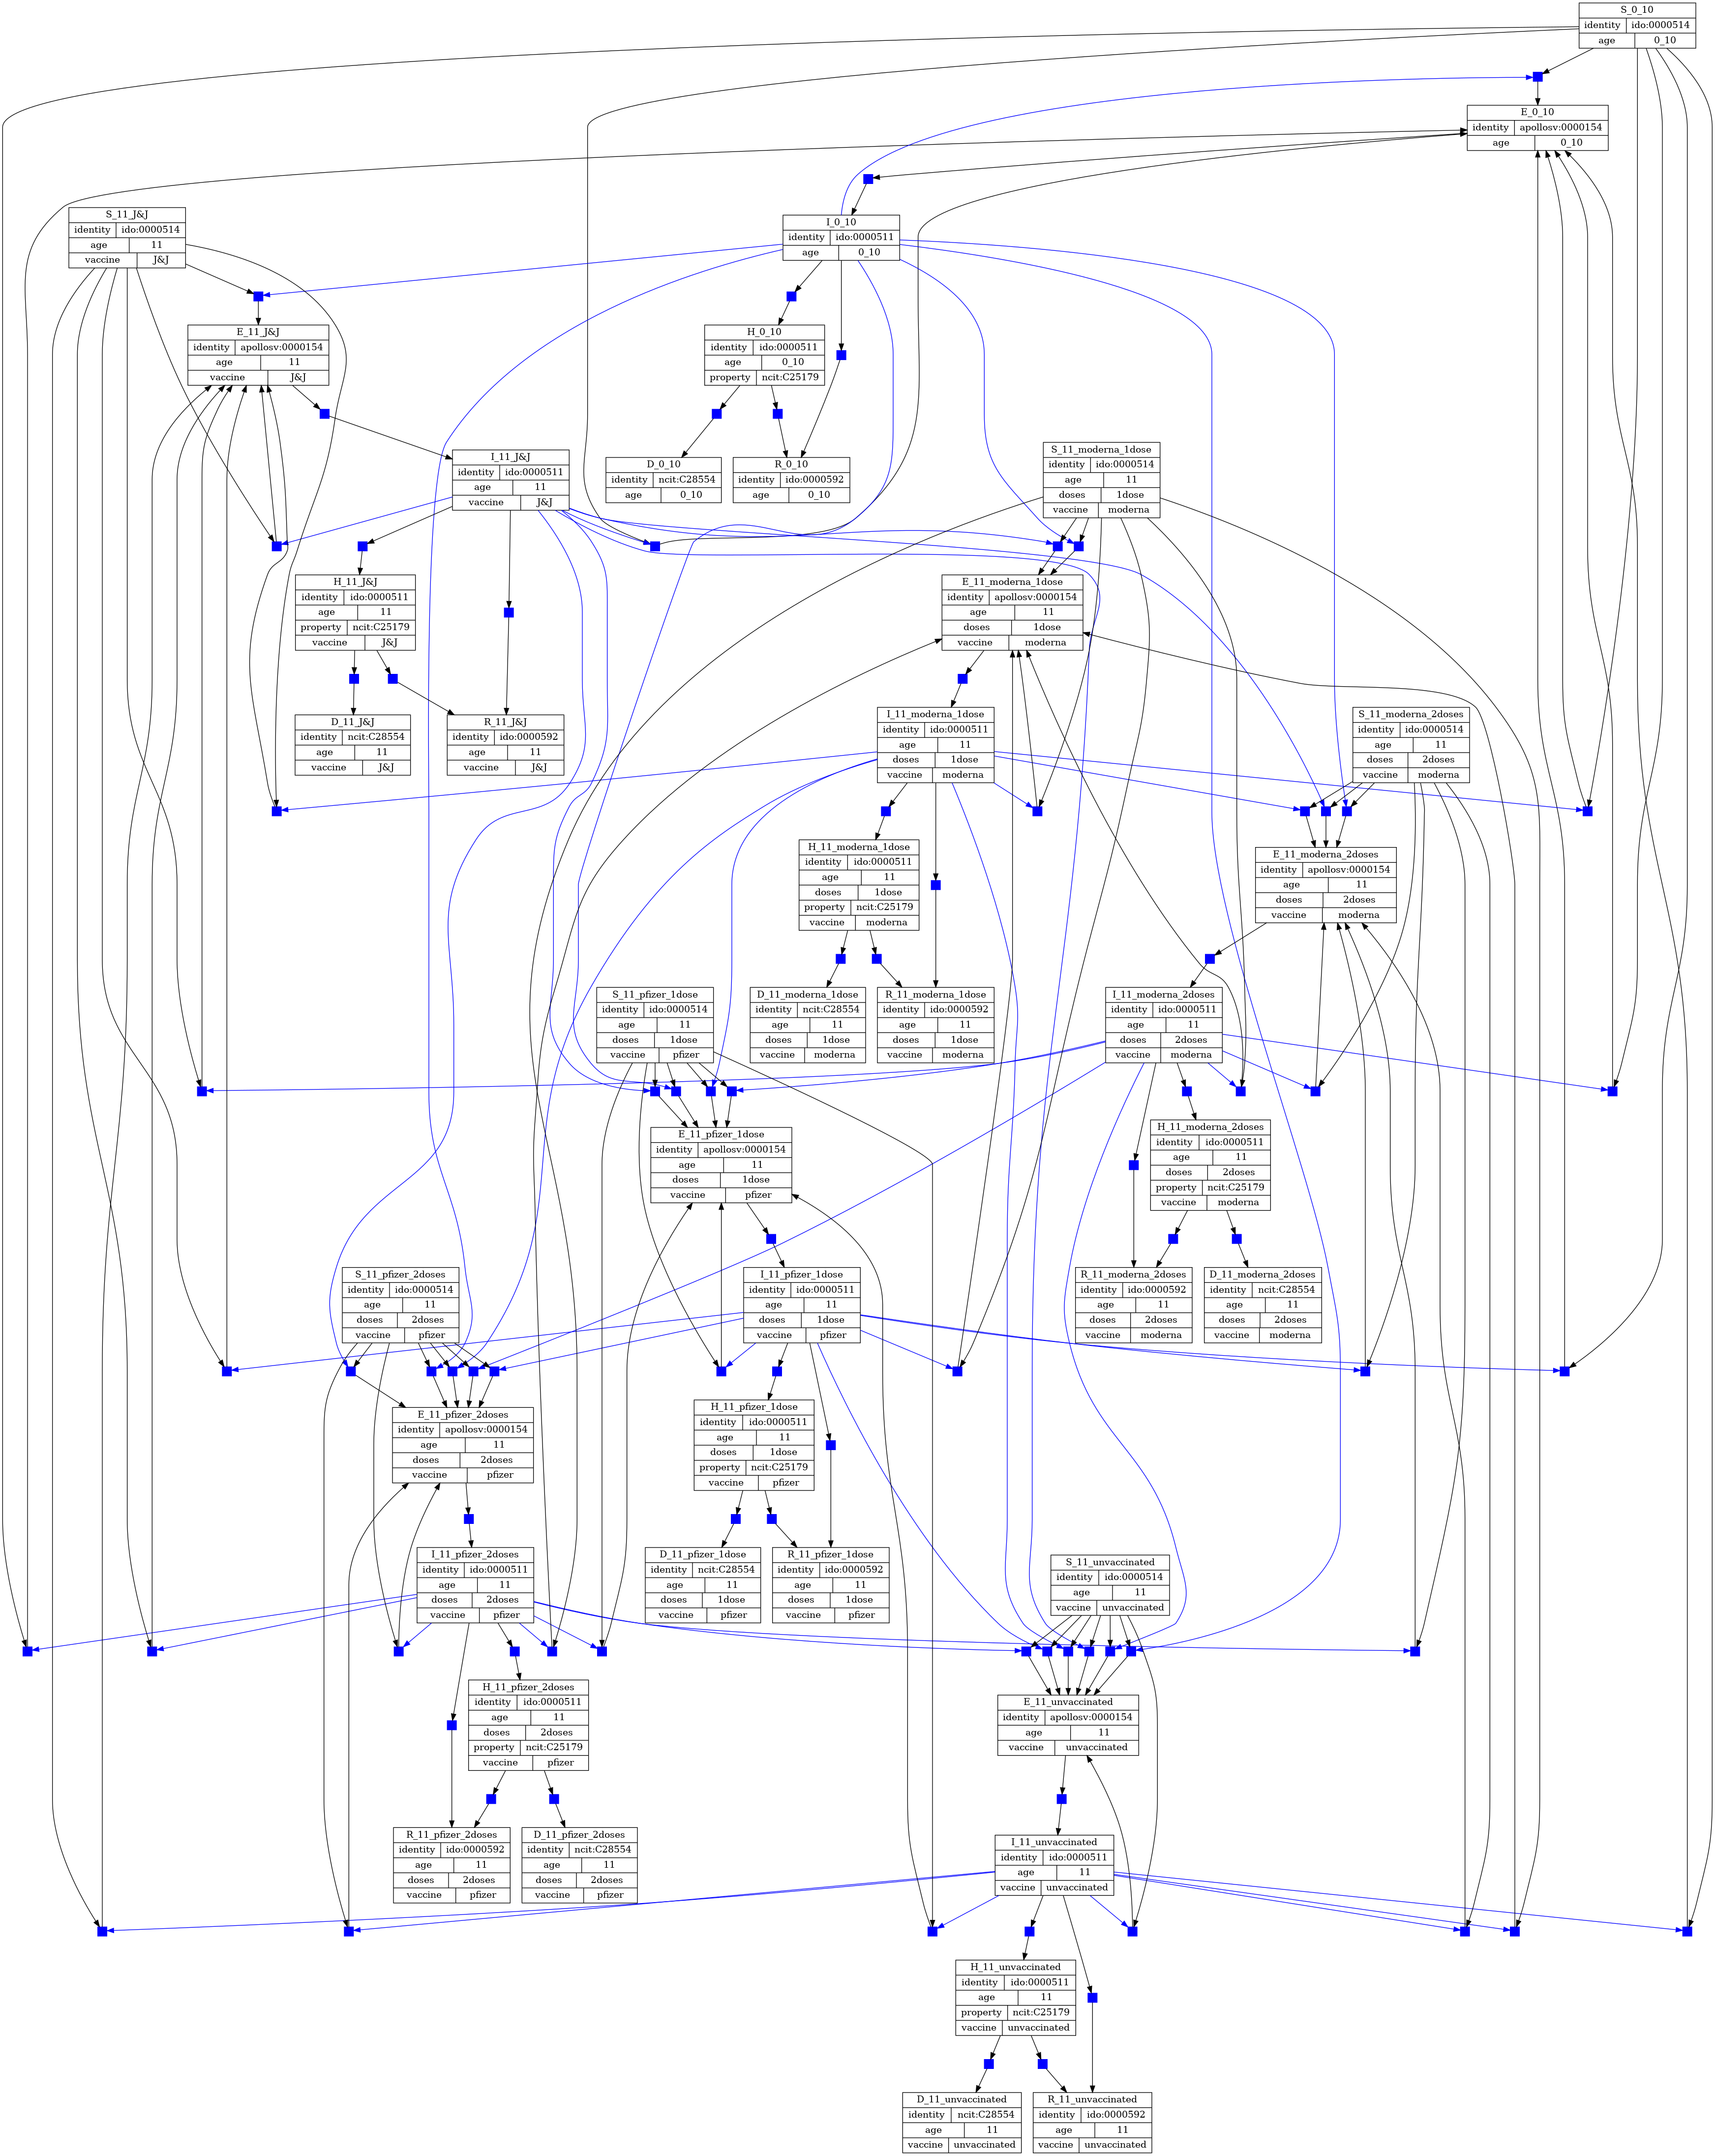

In [6]:
# Stratify vaccinated by number of doses per vaccine: 1 or 2 doses for Moderna, Pfizer and 1 dose for J&J (no stratification needed)
tm_dosing = stratify(
    tm_vaccinated,
    key='doses',
    strata=['1dose', '2doses'],
    structure=[],
    cartesian_control=True,
    # Stratify moderna and pfizer
    concepts_to_stratify={c for c in tm_vaccinated.get_concepts_name_map() if c.endswith(('moderna', 'pfizer'))}
)
GraphicalModel.for_jupyter(tm_dosing)


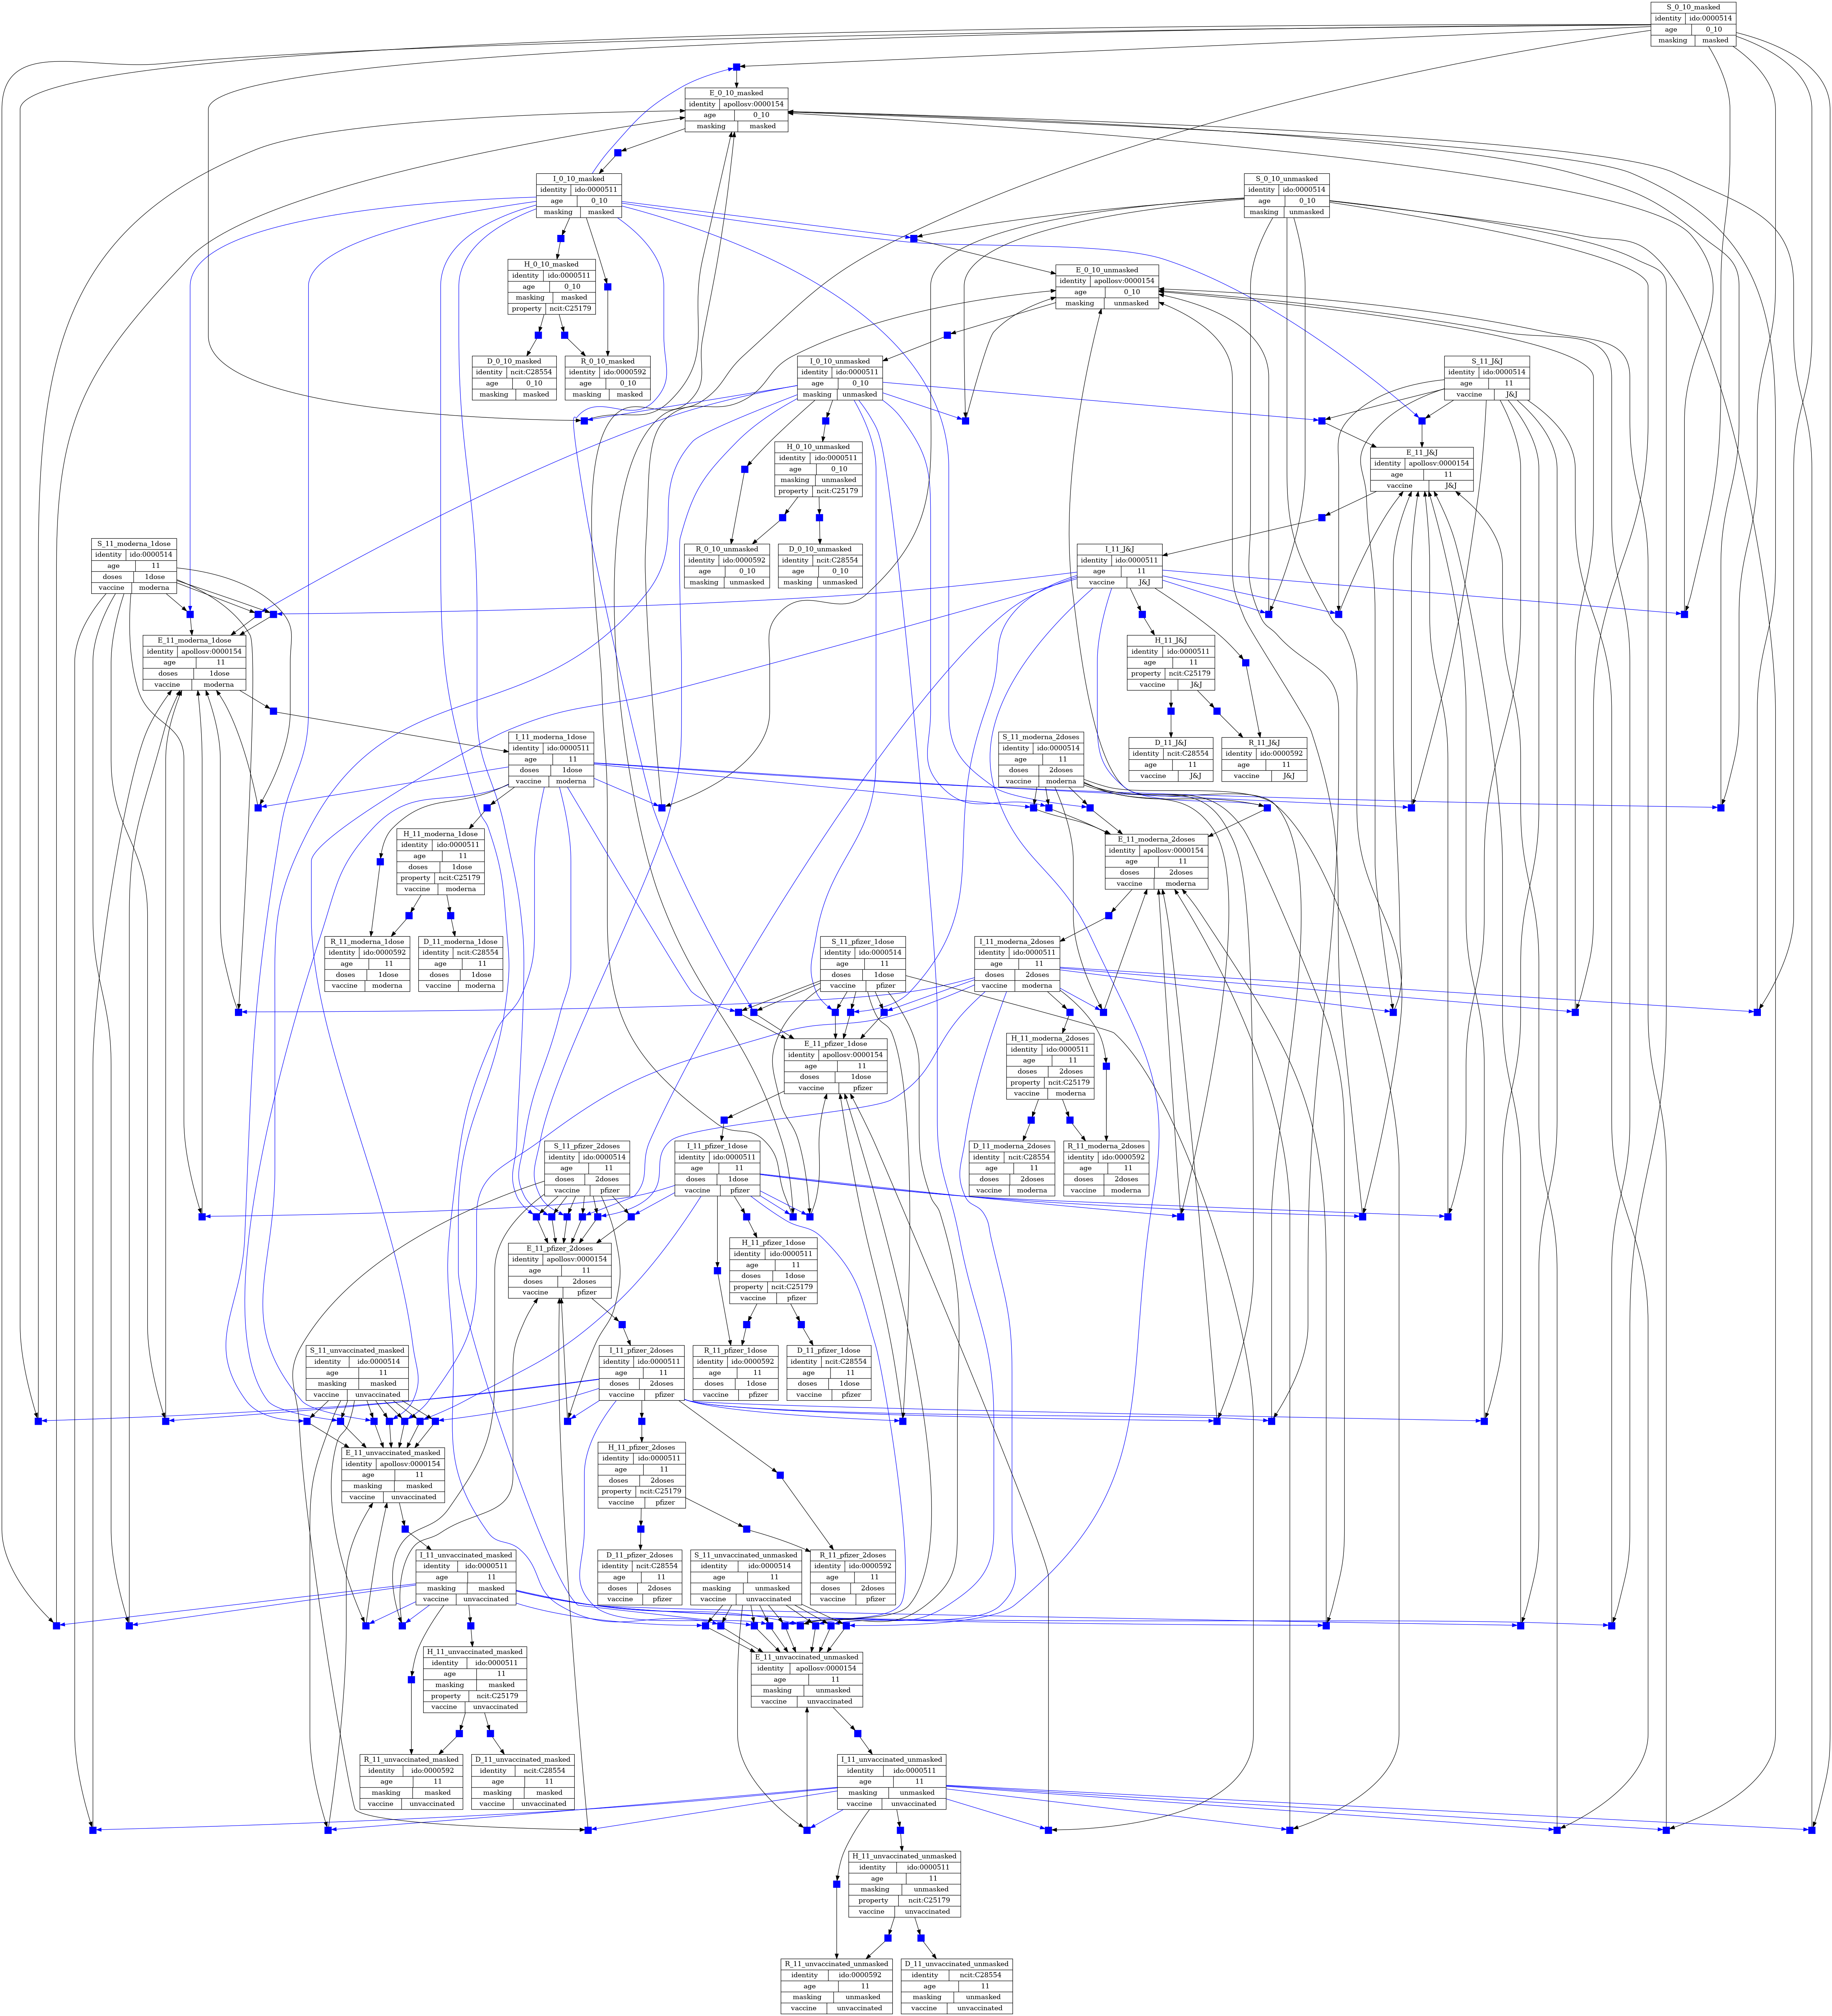

In [7]:
# Stratify unvaccinated by masking compliance
tm_q1_b = stratify(
    tm_dosing,
    key='masking',
    strata=['masked', 'unmasked'],
    structure=[],
    cartesian_control=True,
    # Stratify unvaccinated only
    concepts_to_stratify={c for c in tm_dosing.get_concepts_name_map() if c.endswith(('0_10', 'unvaccinated'))}
)
GraphicalModel.for_jupyter(tm_q1_b)

In [8]:
AskeNetPetriNetModel(Model(tm_q1_b)).to_json_file('eval_scenario2_1_b.json')